In [1]:
import gymnasium
import gymnasium.logger
import gymnasium.wrappers.record_video
import numpy as np
import tensorflow
import tensorflow.keras
import tensorflow.keras.layers
import uuid
import typing
import matplotlib.pyplot as plt

In [2]:
def create_environment(name):
    folder_name = f"./video/{name}/{uuid.uuid4()}"
    env = gymnasium.make(name, render_mode="rgb_array")
    env = gymnasium.wrappers.record_video.RecordVideo(env, folder_name, disable_logger=True)
    return env, folder_name

In [3]:
class QTable:
    def __init__(self, action_space: int, state_space: int, learning_rate: float = 0.3, discount_factor: float = 0.95):
        self.q = np.random.random((state_space, action_space))
        self.alpha = learning_rate
        self.gamma = discount_factor
        
    def update(
        self, states: typing.List[int], next_states: typing.List[int],
        actions_taken: typing.List[int], rewards: typing.List[float]
    ):
        for i in range(len(states)):
            self.q[states[i]][actions_taken[i]] = self.q[states[i]][actions_taken[i]] + self.alpha * (
                rewards[i] + self.gamma * self.max_reward(next_states[i]) - self.q[states[i]][actions_taken[i]]
            )

    def max_reward(self, state: int) -> float:
        return max(self.qt(state))

    def qt(self, state: int) -> typing.List[float]:
        return list(self.q[state])

In [4]:
class QNeural:
    def __init__(self, action_space: int, state_space: int, discount_factor: float = 0.95):
        self.state_space = state_space
        self.action_space = action_space
        self.gamma = discount_factor

        self.model = tensorflow.keras.Sequential([
            tensorflow.keras.layers.Input(shape=(state_space,)),
            tensorflow.keras.layers.Dense(512, activation="relu"),
            tensorflow.keras.layers.Dense(action_space, activation="linear"),
        ])
        self.model.compile(loss='mse', optimizer=tensorflow.keras.optimizers.legacy.Adam())

    def update(
        self, states: typing.List[int], next_states: typing.List[int],
        actions_taken: typing.List[int], rewards: typing.List[float]
    ):
        state_one_hot = tensorflow.one_hot(states, self.state_space)
        state_next_one_hot = tensorflow.one_hot(states, self.state_space)
        masks = tensorflow.one_hot(actions_taken, self.action_space)
        
        target = self.model.predict(state_next_one_hot, verbose=0)
        updated_q_values = rewards + self.gamma * tensorflow.reduce_max(target, axis=1)
        
        q_values = self.model.predict(state_one_hot, verbose=0)
        q_action = tensorflow.reduce_sum(tensorflow.multiply(q_values, masks), axis=1)
        self.model.fit(state_one_hot, q_action, epochs=1, verbose=0)
        
    def qt(self, state: int) -> typing.List[float]:
        state_tensor = tensorflow.one_hot(state, self.state_space)
        state_tensor = tensorflow.expand_dims(state_tensor, 0)
        action_probs = self.model(state_tensor, training=False)
        action = tensorflow.argmax(action_probs[0]).numpy()
        return action

In [5]:
class EpsilonGreedy:
    def __init__(self, action_space: int, state_space: int, epsilon_decay: float = 0.99):
        self.epsilon = 1
        self.epsilon_decay = epsilon_decay
        self.action_space = action_space
        self.state_space = state_space

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        n = np.random.rand()
        if n < self.epsilon:
            action = np.random.randint(0, self.action_space)
        else:
            action = max(q, key=lambda a: a[1])[0]
            
        if self.epsilon > 0.01:
            self.epsilon *= self.epsilon_decay

        return action

In [9]:
class UpperConfidenceBound:
    def __init__(self, action_space: int, state_space: int, p_decay: float = 4.0):
        self.p_decay = p_decay
        self.t = 1
        self.action_space = action_space
        self.state_space = state_space
        self.count_selected = np.ones((state_space, action_space))

    def next_action(self, q: typing.List[typing.Tuple[int, float]], state: int) -> int:
        ut = np.sqrt(
            (self.p_decay * np.log(self.t)) / np.array(self.count_selected[state])
        )
        qt = np.array(q) + ut
        
        action = max(enumerate(qt), key=lambda n: n[1])[0]

        self.count_selected[state][action] += 1
        self.t += 1

        return action

In [7]:
def learn(env, num_episodes: int, selection_method, learning_method):
    batch_size = 32
    update_after_actions = 16
    max_steps_per_episode = 1000
    
    l = learning_method(env.action_space.n, env.observation_space.n)
    s = selection_method(env.action_space.n, env.observation_space.n)

    episode_mean_reward = []

    for episode in range(num_episodes):
        round = 0
        rewards_history = []
        action_history = []
        state_history = []
        state_next_history = []

        if episode % 100 == 0:
            print(f"Episode {episode}...")
        observation, state = env.reset()
        done = False

        while not done and round < max_steps_per_episode:
            round += 1
            
            action = s.next_action(l.qt(observation), observation)

            old_observation = observation
            observation, reward, done, _, state = env.step(action)

            rewards_history.append(reward)
            action_history.append(action)
            state_history.append(old_observation)
            state_next_history.append(old_observation)

            if round % update_after_actions == 0 and len(rewards_history) > batch_size:
                indices = np.random.choice(range(len(rewards_history)), size=batch_size)
                
                state_sample = [state_history[i] for i in indices]
                state_next_sample = [state_next_history[i] for i in indices]
                action_sample = [action_history[i] for i in indices]
                rewards_sample = [rewards_history[i] for i in indices]
            
                l.update(state_sample, state_next_sample, action_sample, rewards_sample)

        episode_mean_reward.append(np.mean(rewards_history))

    env.close()
    return episode_mean_reward

Episode 0...
Episode 100...
Episode 200...
Episode 300...
Episode 400...
Episode 500...
Episode 600...
Episode 700...
Episode 800...
Episode 900...
Episode 1000...
Episode 1100...
Episode 1200...
Episode 1300...
Episode 1400...
Episode 1500...
Episode 1600...
Episode 1700...
Episode 1800...
Episode 1900...
Video in ./video/Taxi-v3/f0855801-c7c4-4fcf-8211-e80ed7a10739


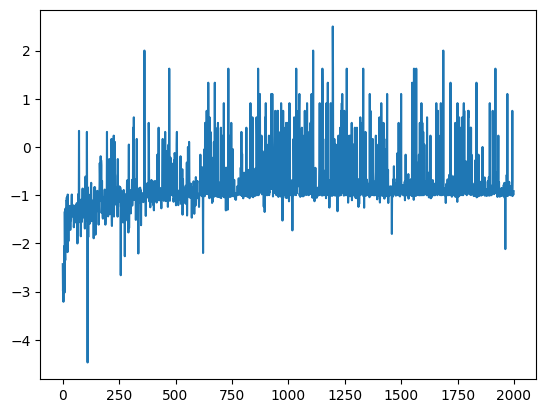

In [10]:
env, folder_name = create_environment("Taxi-v3")
rewards = learn(env, 2000, UpperConfidenceBound, QTable)

print(f"Video in {folder_name}")

plt.plot(rewards)
plt.show()